# Trawl processes simulations

In [1]:
from scipy.stats import levy_stable
import matplotlib.pyplot as plt
import numpy as np
import torch
from math import pi
np.random.seed(seed=1)

The matrix `F` has shape (u-dim, k-dim, timesteps)

The Hurst exponent $H$ equals:

In [2]:
class SaS_cuda():
    def __init__(self, alpha):
        self.alpha = alpha
        
    def rvs(self, size=None):
        """ 'sample_shape is a tuple, array or list'"""
        if size == None:
            flattened = [1]
        else: 
            flattened = np.prod(np.array(size))
        u_1 = torch.cuda.FloatTensor((flattened)).uniform_()
        u_2 = torch.cuda.FloatTensor((flattened)).uniform_()
        gamma = u_1 * pi - pi/2
        w = -torch.log(1-u_2)
        A = torch.sin(self.alpha*gamma)/torch.pow(torch.cos(gamma), 1./self.alpha)
        B = torch.pow(torch.cos(gamma-self.alpha*gamma)/w, (1-self.alpha)/self.alpha)
        return (A*B).cpu().numpy().reshape(size)

In [3]:
test_dist = SaS_cuda(1.5)
test_dist.rvs((10,10, 20)).shape

(10, 10, 20)

In [8]:
class TrawlProcess:
    def __init__(self, alpha, gamma, N=200, n=50, m=5, cuda=True):
        assert(alpha > 1 and alpha <2)
        assert(gamma > 0 and gamma <1)
        assert(alpha > gamma + 1)
        self.H = (alpha-gamma)/alpha
        self.alpha = alpha
        self.gamma = gamma
        self.cuda = cuda
        
        self.M = m*N
        self.N = N
        self.n = n
        self.scaling = np.power((1./(self.N**(2+self.gamma)*(1+self.gamma))), 1./self.alpha)
    
    def sample_paths(self, num_paths=1, plot=True):
        
        F = self._calculate_f()
        S_scaled = np.power(self._calculate_scale(), 1./self.alpha)
        if self.cuda:
            stable_dist = SaS_cuda(self.alpha)
        else: 
            stable_dist = levy_stable(self.alpha, 0.)
            
        paths = np.zeros((num_paths, self.n + 1))
        for j in range(num_paths):
            draw = stable_dist.rvs(size=(self.M, self.M))
            samples = draw * S_scaled
            #samples = samples.reshape(-1, 1, self.N, self.N)
            time_samples =  samples * F
            time_samples = self.scaling*time_samples
            paths[j, 1:] = np.sum(time_samples, axis=(1,2))
        if plot:
            plt.style.use('seaborn-dark')
            fig, ax = plt.subplots(1,1, figsize=(6,6))
            ax.set_xlim(0,1)
            ax.grid()
            
            for path in range(paths.shape[0]):
                ax.plot(np.linspace(0,1, self.n+1), paths[path], 
                        label='path '+str(path))
                if paths.shape[0] < 6:
                    ax.legend()
            plt.title("H = " + str(np.around(self.H, decimals=3)))
            plt.show()
        return paths
        
    
    def _calculate_scale(self):
        S = np.zeros((self.M, self.M), dtype=np.float64)
        for J in range(self.M):
            if J != 0:
                S[:, J] = (J**(-1-self.gamma) - (J+1)**(-1-self.gamma))
        return S
        
    def _calculate_f(self):
        F = np.zeros((self.M, self.M, self.n), dtype=np.float32)
        for timestep in range(self.n):
            # (K, J)
            mask1 =np.triu(np.ones((self.M, self.M), dtype=np.bool)) # J >= K
    
            mask2 = np.zeros((self.M, self.M),  dtype=np.bool)
            mask2[0: timestep*(self.N//self.n), :] = True # K < timestep * (N/n)
            mask3 = np.triu(np.ones((self.M, self.M), dtype=np.bool), -timestep*(self.N//self.n)) # K - timestep (N/n) <= J
            f = np.zeros((self.N,self.N), dtype=np.float64)
    
            m1 = mask1*mask2
            f1 = np.zeros((self.M,self.M), dtype=np.float64)
            # Get a matrix A1 with column values
            A = np.array(range(self.M))
            A = A.reshape(1,-1)
            B = np.ones((self.M,1))
            A1 = (B @ A) # A1.T[k,j] = k
            f1 = A1.T * m1
    
            m2 = (~mask1) * mask2 # J < K and 0 <= k < timestep* N/n
            f2 = m2 * A1 
    
            m3 = mask1 * (~mask2)
            f3 = m3 * timestep*(self.N//self.n)
    
            m4 = (~mask1) * (~mask2) * mask3
            f4 = (timestep * (self.N//self.n) + A1 - A1.T) * m4
            f = f1 + f2 + f3 + f4
            #print(f.shape)
            F[:, :, timestep] = f
        
        F = np.transpose(F, (2,0,1))
        return F
   

In [ ]:
%%time
trawl = TrawlProcess(1.8, 0.5, cuda=True)
#print(trawl.H)
S = trawl._calculate_scale()
paths = trawl.sample_paths(num_paths=3)
    

## Tasting the F mapping

In [161]:
n = 10
N=100
M=400
alpha = 1.8
gamma = 0.3
scaling = np.power((1./(N**(2+gamma)*(1+gamma))), 1./alpha)
F = np.zeros((M, M, n), dtype=np.float32)
for timestep in range(1, n+1):
    mask1 =np.triu(np.ones((M, M), dtype=np.bool)) # J >= K
    mask2 = np.zeros((M, M),  dtype=np.bool)
    mask2[0: timestep*(N//n), :] = True # K < timestep * (N/n)
    
    m1 = mask1*mask2
    f1 = np.zeros((M,M), dtype=np.float64)
    # Get a matrix A1 with column values
    A = np.array(range(M))
    A = A.reshape(1,-1)
    B = np.ones((M,1))
    A1 = (B @ A) # A1.T[k,j] = k
    f1 = A1.T * m1
    
    m2 = (~mask1) * mask2 # J < K and 0 <= k < timestep* N/n
    f2 = m2 * A1 
    
    m3 = mask1 * (~mask2)
    f3 = m3 * timestep*(N//n)
    
    mask3 = np.triu(np.ones((M, M), dtype=np.bool), -timestep*(N//n)) # K - timestep (N/n) <= J
    m4 = (~mask1) * (~mask2) * mask3
    f4 = (timestep * (N//n) + A1 - A1.T) * m4
    f = f1 + f2 + f3 + f4
    F[:, :, timestep-1] = f
    
F = np.transpose(F, (2,0,1))

In [162]:
F.shape

(10, 400, 400)

(0, 400)

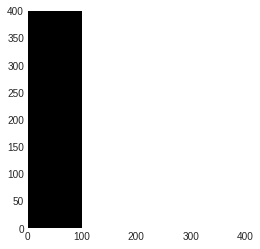

In [163]:
plt.imshow(mask2.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

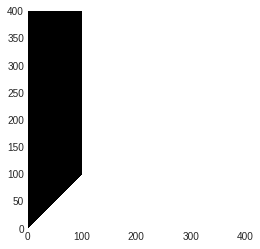

In [164]:
plt.imshow(m1.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

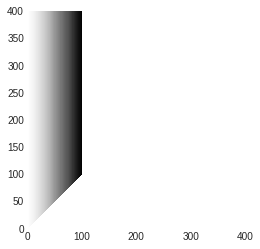

In [165]:
plt.imshow(f1.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

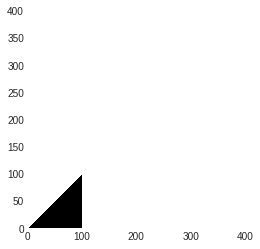

In [166]:
plt.imshow(m2.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

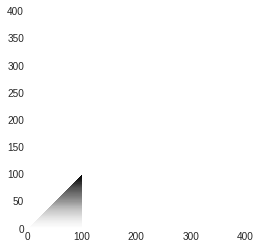

In [167]:
plt.imshow(f2.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

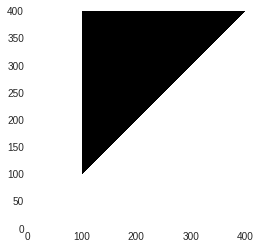

In [168]:
plt.imshow(f3.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

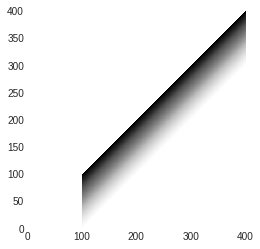

In [169]:
plt.imshow(f4.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

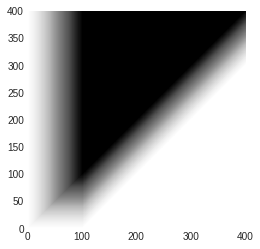

In [170]:
plt.imshow(f.T)
plt.xlim(0,M)
plt.ylim(0,M)

(0, 400)

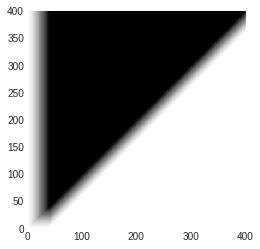

In [171]:
plt.imshow(F[3, :, :].T)
plt.xlim(0,M)
plt.ylim(0,M)

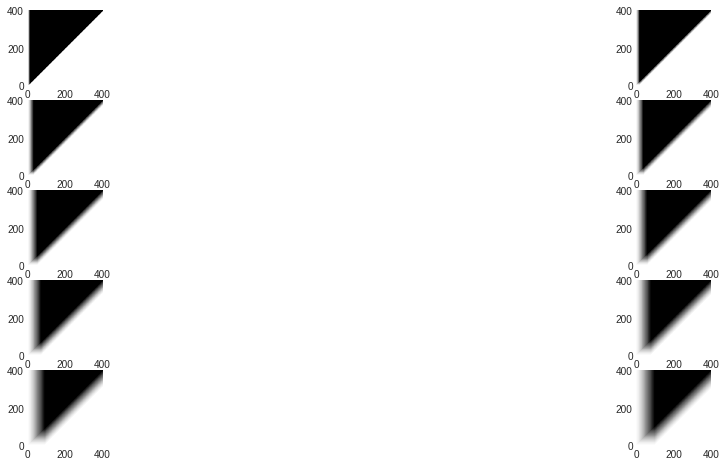

In [172]:
fig, axes = plt.subplots(n//2,2, figsize=(20,8))
for j in range(n):
    axes[j//2, j%2].imshow(F[j, :, :].T)
    axes[j//2, j%2].set_xlim(0, M)
    axes[j//2, j%2].set_ylim(0, M)
#plt.tight_layout()
    

(0, 5)

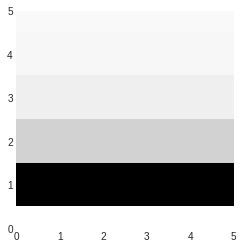

In [173]:
stable_dist = SaS_cuda(alpha)
S = np.zeros((M, M), dtype=np.float64)
for J in range(M):
    if J != 0:
        S[:, J] = (J**(-1-gamma) - (J+1)**(-1-gamma))
S_scaled = np.power(S, 1./alpha)
plt.imshow(S.T)
plt.xlim(0,5)
plt.ylim(0,5)

In [174]:
draw = stable_dist.rvs(size=(M, M))
samples = draw * S_scaled
time_samples =  samples * F
time_samples = scaling*time_samples


In [176]:
time_samples.shape

(10, 400, 400)